In [3]:
import os
import numpy as np
import json
from itertools import product

class Node():
    '''
    Class for representing a node in the ImageNet/WordNet hierarchy. 
    '''
    def __init__(self, wnid, parent_wnid=None, name=""):
        """
        Args:
            wnid (str) : WordNet ID for synset represented by node
            parent_wnid (str) : WordNet ID for synset of node's parent
            name (str) : word/human-interpretable description of synset 
        """

        self.wnid = wnid
        self.name = name
        self.class_num = -1
        self.parent_wnid = parent_wnid
        self.descendant_count_in = 0
        self.descendants_all = set()
    
    def add_child(self, child):
        """
        Add child to given node.

        Args:
            child (Node) : Node object for child
        """
        child.parent_wnid = self.wnid
    
    def __str__(self):
        return f'Name: ({self.name}), ImageNet Class: ({self.class_num}), Descendants: ({self.descendant_count_in})'
    
    def __repr__(self):
        return f'Name: ({self.name}), ImageNet Class: ({self.class_num}), Descendants: ({self.descendant_count_in})'

class ImageNetHierarchy():
    '''
    Class for representing ImageNet/WordNet hierarchy. 
    '''
    def __init__(self, ds_path, ds_info_path):
        """
        Args:
            ds_path (str) : Path to ImageNet dataset
            ds_info_path (str) : Path to supplementary files for the ImageNet dataset 
                                 ('wordnet.is_a.txt', 'words.txt' and 'imagenet_class_index.json')
                                 which can be obtained from http://image-net.org/download-API.

        """
        self.tree = {}

        ret = self.load_imagenet_info(ds_path, ds_info_path)
        self.in_wnids, self.wnid_to_name, self.wnid_to_num, self.num_to_name = ret
            
        with open(os.path.join(ds_info_path, 'wordnet.is_a.txt'), 'r') as f:
            for line in f.readlines():
                parent_wnid, child_wnid = line.strip('\n').split(' ')
                parentNode = self.get_node(parent_wnid)
                childNode = self.get_node(child_wnid)
                parentNode.add_child(childNode)
                
        for wnid in self.in_wnids:
            self.tree[wnid].descendant_count_in = 0
            self.tree[wnid].class_num = self.wnid_to_num[wnid]
            
        for wnid in self.in_wnids:
            node = self.tree[wnid]
            while node.parent_wnid is not None:
                self.tree[node.parent_wnid].descendant_count_in += 1
                self.tree[node.parent_wnid].descendants_all.update(node.descendants_all)
                self.tree[node.parent_wnid].descendants_all.add(node.wnid)
                node = self.tree[node.parent_wnid]
        
        del_nodes = [wnid for wnid in self.tree \
                     if (self.tree[wnid].descendant_count_in == 0 and self.tree[wnid].class_num == -1)]
        for d in del_nodes:
            self.tree.pop(d, None)
                        
        assert all([k.descendant_count_in > 0 or k.class_num != -1 for k in self.tree.values()])

        self.wnid_sorted = sorted(sorted([(k, v.descendant_count_in, len(v.descendants_all)) \
                                        for k, v in self.tree.items()
                                        ],
                                        key=lambda x: x[2], 
                                        reverse=True
                                        ),
                                key=lambda x: x[1], 
                                reverse=True
                                )

    @staticmethod
    def load_imagenet_info(ds_path, ds_info_path):
        """
        Get information about mapping between ImageNet wnids/class numbers/class names.

        Args:
            ds_path (str) : Path to ImageNet dataset
            ds_info_path (str) : Path to supplementary files for the ImageNet dataset 
                                 ('wordnet.is_a.txt', 'words.txt', 'imagenet_class_index.json')
                                 which can be obtained from http://image-net.org/download-API.

        """
        files = os.listdir(os.path.join(ds_path, 'val'))
        in_wnids = [f for f in files if f[0]=='n'] 

        f = open(os.path.join(ds_info_path, 'words.txt'))
        wnid_to_name = [l.strip() for l in f.readlines()]
#         print(wnid_to_name)
#         print(wnid_to_name[0].split('\t'))
        wnid_to_name = {l.split('\t')[0]: l.split('\t')[1] \
                             for l in wnid_to_name}

        with open(os.path.join(ds_info_path, 'imagenet_class_index.json'), 'r') as f:
            base_map = json.load(f)
            wnid_to_num = {v[0]: int(k) for k, v in base_map.items()}
            num_to_name = {int(k): v[1] for k, v in base_map.items()}

        return in_wnids, wnid_to_name, wnid_to_num, num_to_name

    def get_node(self, wnid):
        """
        Add node to tree.

        Args:
            wnid (str) : WordNet ID for synset represented by node

        Returns:
            A node object representing the specified wnid.
        """
        if wnid not in self.tree:
            self.tree[wnid] = Node(wnid, name=self.wnid_to_name[wnid])
        return self.tree[wnid]


    def is_ancestor(self, ancestor_wnid, child_wnid):
        """
        Check if a node is an ancestor of another.

        Args:
            ancestor_wnid (str) : WordNet ID for synset represented by ancestor node
            child_wnid (str) : WordNet ID for synset represented by child node

        Returns:
            A boolean variable indicating whether or not the node is an ancestor
        """
        return (child_wnid in self.tree[ancestor_wnid].descendants_all)

    
    def get_descendants(self, node_wnid, in_imagenet=False):
        """
        Get all descendants of a given node.

        Args:
            node_wnid (str) : WordNet ID for synset for node
            in_imagenet (bool) : If True, only considers descendants among 
                                ImageNet synsets, else considers all possible
                                descendants in the WordNet hierarchy

        Returns:
            A set of wnids corresponding to all the descendants
        """        
        if in_imagenet:
            return set([self.wnid_to_num[ww] for ww in self.tree[node_wnid].descendants_all
                        if ww in set(self.in_wnids)])
        else:
            return self.tree[node_wnid].descendants_all
    
    def get_superclasses(self, n_superclasses, 
                         ancestor_wnid=None, superclass_lowest=None, 
                         balanced=True):
        """
        Get superclasses by grouping together classes from the ImageNet dataset.

        Args:
            n_superclasses (int) : Number of superclasses desired
            ancestor_wnid (str) : (optional) WordNet ID that can be used to specify
                                common ancestor for the selected superclasses
            superclass_lowest (set of str) : (optional) Set of WordNet IDs of nodes
                                that shouldn't be further sub-classes
            balanced (bool) : If True, all the superclasses will have the same number
                            of ImageNet subclasses

        Returns:
            superclass_wnid (list): List of WordNet IDs of superclasses
            class_ranges (list of sets): List of ImageNet subclasses per superclass
            label_map (dict): Mapping from class number to human-interpretable description
                            for each superclass
        """             
        
        assert superclass_lowest is None or \
               not any([self.is_ancestor(s1, s2) for s1, s2 in product(superclass_lowest, superclass_lowest)])
         
        superclass_info = []
        for (wnid, ndesc_in, ndesc_all) in self.wnid_sorted:
            
            if len(superclass_info) == n_superclasses:
                break
                
            if ancestor_wnid is None or self.is_ancestor(ancestor_wnid, wnid):
                keep_wnid = [True] * (len(superclass_info) + 1)
                superclass_info.append((wnid, ndesc_in))
                
                for ii, (w, d) in enumerate(superclass_info):
                    if self.is_ancestor(w, wnid):
                        if superclass_lowest and w in superclass_lowest:
                            keep_wnid[-1] = False
                        else:
                            keep_wnid[ii] = False
                
                for ii in range(len(superclass_info) - 1, -1, -1):
                    if not keep_wnid[ii]:
                        superclass_info.pop(ii)
            
        superclass_wnid = [w for w, _ in superclass_info]
        class_ranges, label_map = self.get_subclasses(superclass_wnid, 
                                    balanced=balanced)
                
        return superclass_wnid, class_ranges, label_map


    def get_subclasses(self, superclass_wnid, balanced=True):
        """
        Get ImageNet subclasses for a given set of superclasses from the WordNet 
        hierarchy. 

        Args:
            superclass_wnid (list): List of WordNet IDs of superclasses
            balanced (bool) : If True, all the superclasses will have the same number
                            of ImageNet subclasses

        Returns:
            class_ranges (list of sets): List of ImageNet subclasses per superclass
            label_map (dict): Mapping from class number to human-interpretable description
                            for each superclass
        """      
        ndesc_min = min([self.tree[w].descendant_count_in for w in superclass_wnid]) 
        class_ranges, label_map = [], {}
        for ii, w in enumerate(superclass_wnid):
            descendants = self.get_descendants(w, in_imagenet=True)
            if balanced and len(descendants) > ndesc_min:
                descendants = set([dd for ii, dd in enumerate(sorted(list(descendants))) if ii < ndesc_min])
            class_ranges.append(descendants)
            label_map[ii] = self.tree[w].name
            
        for i in range(len(class_ranges)):
            for j in range(i + 1, len(class_ranges)):
                assert(len(class_ranges[i].intersection(class_ranges[j])) == 0)
                
        return class_ranges, label_map

def common_superclass_wnid(group_name):
    """
        Get WordNet IDs of common superclasses. 

        Args:
            group_name (str): Name of group

        Returns:
            superclass_wnid (list): List of WordNet IDs of superclasses
        """    
    common_groups = {

        # ancestor_wnid = 'n00004258'
        'living_9': ['n02084071', #dog, domestic dog, Canis familiaris
                    'n01503061', # bird
                    'n01767661', # arthropod
                    'n01661091', # reptile, reptilian
                    'n02469914', # primate
                    'n02512053', # fish
                    'n02120997', # feline, felid
                    'n02401031', # bovid
                    'n01627424', # amphibian
                    ],

        'mixed_10': [
                     'n02084071', #dog,
                     'n01503061', #bird 
                     'n02159955', #insect 
                     'n02484322', #monkey 
                     'n02958343', #car 
                     'n02120997', #feline 
                     'n04490091', #truck 
                     'n13134947', #fruit 
                     'n12992868', #fungus 
                     'n02858304', #boat 
                     ],

        'mixed_13': ['n02084071', #dog,
                     'n01503061', #bird (52)
                     'n02159955', #insect (27)
                     'n03405725', #furniture (21)
                     'n02512053', #fish (16),
                     'n02484322', #monkey (13)
                     'n02958343', #car (10)
                     'n02120997', #feline (8),
                     'n04490091', #truck (7)
                     'n13134947', #fruit (7)
                     'n12992868', #fungus (7)
                     'n02858304', #boat (6)  
                     'n03082979', #computer(6)
                    ],

        # Dataset from Geirhos et al., 2018: arXiv:1811.12231
        'geirhos_16': ['n02686568', #aircraft (3)
                       'n02131653', #bear (3)
                       'n02834778', #bicycle (2)
                       'n01503061', #bird (52)
                       'n02858304', #boat (6)
                       'n02876657', #bottle (7)
                       'n02958343', #car (10)
                       'n02121808', #cat (5)
                       'n03001627', #char (4)
                       'n03046257', #clock (3)
                       'n02084071', #dog (116)
                       'n02503517', #elephant (2)
                       'n03614532', #keyboard (3)
                       'n03623556', #knife (2)
                       'n03862676', #oven (2)
                       'n04490091', #truck (7)
                      ],
        'big_12':  ['n02084071', #dog (100+)
                     'n04341686', #structure (55)
                     'n01503061', #bird (52)
                     'n03051540', #clothing (48)
                     'n04576211', #wheeled vehicle
                     'n01661091', #reptile, reptilian (36)
                     'n02075296', #carnivore
                     'n02159955', #insect (27)
                     'n03800933', #musical instrument (26)
                     'n07555863', #food (24)
                     'n03405725', #furniture (21)
                     'n02469914', #primate (20)
                   ],
        'mid_12':  ['n02084071', #dog (100+)
                      'n01503061', #bird (52)
                      'n04576211', #wheeled vehicle
                      'n01661091', #reptile, reptilian (36)
                      'n02075296', #carnivore
                      'n02159955', #insect (27)
                      'n03800933', #musical instrument (26)
                      'n07555863', #food (24)
                      'n03419014', #garment (24)
                      'n03405725', #furniture (21)
                      'n02469914', #primate (20)
                      'n02512053', #fish (16)
                    ]
    }

    if group_name in common_groups:
        superclass_wnid = common_groups[group_name]
        return superclass_wnid
    else:
        raise ValueError("Custom group does not exist")


In [4]:
ds_path="/home/gbhatt2/imagenet/robustness/" # location of 
ds_info_path="../imgnt_meta/"

In [5]:
in_hier = ImageNetHierarchy(ds_path,
                            ds_info_path)

In [6]:
for cnt, (wnid, ndesc_in, ndesc_total) in enumerate(in_hier.wnid_sorted):
    if cnt < 10:
        print(f"WordNet ID: {wnid}, Name: {in_hier.wnid_to_name[wnid]}, #ImageNet descendants: {ndesc_in}")

WordNet ID: n00001740, Name: entity, #ImageNet descendants: 1000
WordNet ID: n00001930, Name: physical entity, #ImageNet descendants: 992
WordNet ID: n00002684, Name: object, physical object, #ImageNet descendants: 946
WordNet ID: n00003553, Name: whole, unit, #ImageNet descendants: 936
WordNet ID: n00021939, Name: artifact, artefact, #ImageNet descendants: 521
WordNet ID: n00004258, Name: living thing, animate thing, #ImageNet descendants: 407
WordNet ID: n00004475, Name: organism, being, #ImageNet descendants: 407
WordNet ID: n00015388, Name: animal, animate being, beast, brute, creature, fauna, #ImageNet descendants: 398
WordNet ID: n03575240, Name: instrumentality, instrumentation, #ImageNet descendants: 348
WordNet ID: n01466257, Name: chordate, #ImageNet descendants: 207


In [7]:
ancestor_wnid = 'n02120997'
print(f"Superclass | WordNet ID: {ancestor_wnid}, Name: {in_hier.wnid_to_name[ancestor_wnid]}")
for cnt, wnid in enumerate(in_hier.tree[ancestor_wnid].descendants_all):
    if wnid in in_hier.in_wnids:
        print(f"ImageNet subclass | WordNet ID: {wnid}, Name: {in_hier.wnid_to_name[wnid]}")

Superclass | WordNet ID: n02120997, Name: feline, felid
ImageNet subclass | WordNet ID: n02129604, Name: tiger, Panthera tigris
ImageNet subclass | WordNet ID: n02128757, Name: snow leopard, ounce, Panthera uncia
ImageNet subclass | WordNet ID: n02128925, Name: jaguar, panther, Panthera onca, Felis onca
ImageNet subclass | WordNet ID: n02127052, Name: lynx, catamount
ImageNet subclass | WordNet ID: n02128385, Name: leopard, Panthera pardus
ImageNet subclass | WordNet ID: n02129165, Name: lion, king of beasts, Panthera leo
ImageNet subclass | WordNet ID: n02125311, Name: cougar, puma, catamount, mountain lion, painter, panther, Felis concolor
ImageNet subclass | WordNet ID: n02130308, Name: cheetah, chetah, Acinonyx jubatus


In [8]:
n_classes =30
superclass_wnid, class_ranges, label_map = in_hier.get_superclasses(n_classes,
                                           ancestor_wnid='n00001740',
                                           superclass_lowest=None,
                                           balanced=False)


# superclass_wnid = common_superclass_wnid('geirhos_16')
# class_ranges, label_map = in_hier.get_subclasses(superclass_wnid, balanced=False)


In [9]:
for wnid in superclass_wnid:
    print(wnid, in_hier.wnid_to_name[wnid])

n02159955 insect
n02092468 terrier
n04014297 protective covering, protective cover, protection
n03419014 garment
n04531098 vessel
n03405725 furniture, piece of furniture, article of furniture
n03791235 motor vehicle, automotive vehicle
n01726692 snake, serpent, ophidian
n02098550 sporting dog, gun dog
n02087551 hound, hound dog
n02512053 fish
n02000954 wading bird, wader
n02394477 even-toed ungulate, artiodactyl, artiodactyl mammal
n03699975 machine
n04530566 vessel, watercraft
n02484322 monkey
n07570720 nutriment, nourishment, nutrition, sustenance, aliment, alimentation, victuals
n04451818 tool
n07707451 vegetable, veggie, veg
n03733925 measuring instrument, measuring system, measuring device
n02913152 building, edifice
n03528263 home appliance, household appliance
n03278248 electronic equipment
n02083346 canine, canid
n03414162 game equipment
n02104523 shepherd dog, sheepdog, sheep dog
n01674464 lizard
n04586932 wind instrument, wind
n01525720 oscine, oscine bird
n03738472 mechanism

In [10]:
# Number of classes 
c=[len(list(j)) for j in class_ranges]
print((np.asarray(c)).sum())

467


In [17]:
import torch
gt = torch.load("gt_dataset=V1.pth").numpy()
print("Loading the Multihead models!!!")
preds = torch.load("predictions_sh=False_mh=True_ff=False_feat_dim=2048_dataset=V1.pth").cpu().numpy()
softmax = torch.load("softmax_sh=False_mh=True_ff=False_feat_dim=2048_dataset=V1.pth").cpu().numpy()

Loading the Multihead models!!!


In [18]:
# from imagenet_tree import *
from mapping import *
from sklearn.metrics import confusion_matrix

class superclass:
	def __init__(self, superclass_wnid, class_ranges, label_map, gt):
		self.superclass_wnid = superclass_wnid
		self.class_ranges = [sorted(np.asarray(list(j))) for j in class_ranges]
		self.label_map = label_map
		self.gt = gt
		self.get_gt_superclass_mapping()

	def get_gt_superclass_mapping(self):
		self.class_to_superclass = np.zeros(1000).astype(np.int32) # 0 is for the reject class. 
		for i, subclasses  in enumerate(self.class_ranges):
			self.class_to_superclass[subclasses] = (i+1)
		self.class_ranges=[(self.class_to_superclass==0).nonzero()[0]]+self.class_ranges
		self.superclass_wnid = ['NA']+self.superclass_wnid

		self.reduced_gt = self.class_to_superclass[self.gt]


	def get_superclass_performance(self, predictions):
		# return accuracy and confusion matrix 
		reduced_predictions = self.class_to_superclass[predictions]
		accuracy = ((reduced_predictions == self.reduced_gt).sum())/len(self.gt)
		cmat = confusion_matrix(self.reduced_gt, reduced_predictions, normalize='true')

		return accuracy, cmat

	def get_restricted_full(self, predictions):
		# This returns the accuracy on all the subclasses (excluding the rejected class)
		rejected_idx = self.reduced_gt.nonzero()[0]
		accuracy = ((predictions[rejected_idx] == self.gt[rejected_idx]).sum())/len(rejected_idx)
		return accuracy


	def get_subclass_accuracies(self, logits):
		# This is just reduced search space classification
		# Assuming that it has correctly done the superclass classification
		subclass_corr = [] 
		subclass_tot=[]

		for i in range(1, len(self.superclass_wnid)):
			idx = self.reduced_gt==i
			subclass_tot.append((idx).sum())
			subclasses = self.class_ranges[i]
			subclass_preds = logits[idx][:, self.class_ranges[i]].argmax(axis=-1)
			subclass_preds = np.asarray(subclasses)[subclass_preds]
			acc = (subclass_preds == self.gt[idx]).sum()
			subclass_corr.append(acc)

		return np.asarray(subclass_corr), np.asarray(subclass_tot)

In [19]:
o = superclass(superclass_wnid, class_ranges, label_map, gt)

In [20]:
acc_all=[]
all_mat=[]
for i in range(9):
    accuracy, cmat = o.get_superclass_performance(preds[i])
    all_mat.append(cmat)
    acc_all.append(accuracy)

all_mat = np.stack(all_mat, axis=0)

In [22]:
# Plain superclass classification
for i in range(9):
#     print(2**(i+3), acc_all[i])
    print(f"Nesting Dim {2**(i+3)} and performance {100*acc_all[i]}%")

Nesting Dim 8 and performance 85.572%
Nesting Dim 16 and performance 88.672%
Nesting Dim 32 and performance 89.482%
Nesting Dim 64 and performance 89.818%
Nesting Dim 128 and performance 89.97%
Nesting Dim 256 and performance 90.114%
Nesting Dim 512 and performance 90.182%
Nesting Dim 1024 and performance 90.216%
Nesting Dim 2048 and performance 90.214%


In [23]:
print("0-th class is reject (NA)")
per_class_acc = np.diagonal(all_mat, axis1=1, axis2=2)/all_mat.sum(axis=-1)
for i in range(9):
    print(f"Nesting Dimension {2**(i+3)}")
    print(per_class_acc[i])
    worst_class = np.argmin(per_class_acc[i]); print(o.superclass_wnid[worst_class])
    print(f"Worst SuperClass {in_hier.wnid_to_name[o.superclass_wnid[worst_class]]} with {len(o.class_ranges[worst_class])} subclasses")

0-th class is reject (NA)
Nesting Dimension 8
[0.89414634 0.95111111 0.88461538 0.645      0.70166667 0.64173913
 0.76857143 0.87619048 0.92941176 0.89529412 0.75411765 0.9075
 0.96       0.91466667 0.72142857 0.94461538 0.94       0.78666667
 0.45       0.85333333 0.775      0.76833333 0.67166667 0.67
 0.94833333 0.79666667 0.86166667 0.92363636 0.81454545 0.95090909
 0.624     ]
n04451818
Worst SuperClass tool with 12 subclasses
Nesting Dimension 16
[0.91752345 0.95777778 0.91153846 0.7375     0.76833333 0.73565217
 0.78761905 0.9        0.93176471 0.93294118 0.85176471 0.9175
 0.9625     0.936      0.75571429 0.94       0.95538462 0.79833333
 0.66666667 0.88333333 0.82333333 0.77333333 0.75166667 0.72666667
 0.945      0.835      0.88       0.94       0.84727273 0.96727273
 0.68      ]
n04451818
Worst SuperClass tool with 12 subclasses
Nesting Dimension 32
[0.92382739 0.96222222 0.92461538 0.75333333 0.7675     0.75304348
 0.80857143 0.90095238 0.93411765 0.93411765 0.85529412 0.931

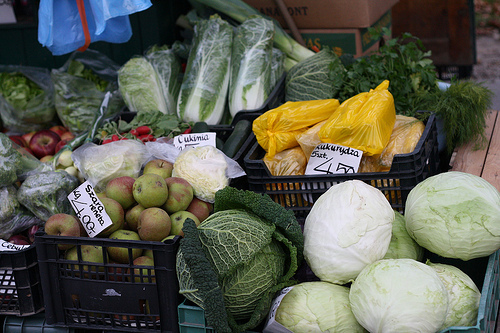

In [24]:
# Visualization of images from vegetable superclass class..
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
Image.open(f"val/n07714571/ILSVRC2012_val_00003020.JPEG")

Text(0.5, 1.0, 'Difference in Confusion Matrix of Rep. Size 16 and 8. Superclass 18 has the biggest change.')

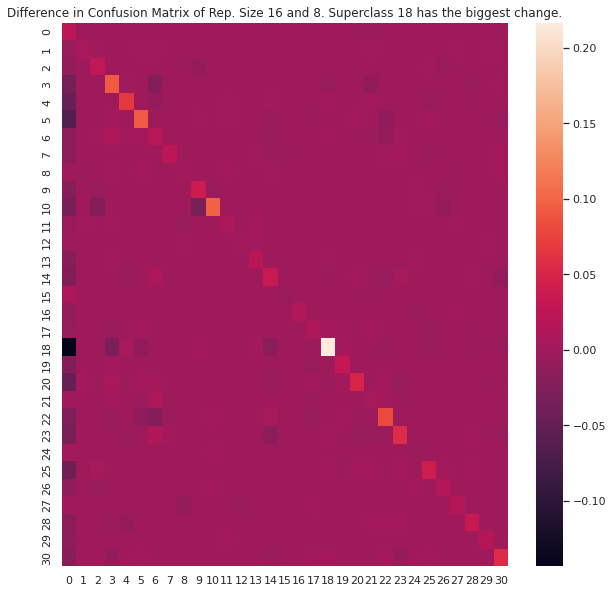

In [26]:
m=0
sns.set(rc={"figure.figsize":(10, 10)})
sns.heatmap((all_mat[1][m:, m:]-all_mat[0]))
plt.title("Difference in Confusion Matrix of Rep. Size 16 and 8. Superclass 18 has the biggest change.")

## Accuracy over subclasses

In [44]:
all_subclass_acc = [o.get_restricted_full(preds[i]) for i in range(9)]

In [46]:
all_acc=[]
for i in range(9):
    subclass_corr, subclass_tot = o.get_subclass_accuracies(softmax[i])
    all_acc.append(subclass_corr/subclass_tot)
all_acc = np.asarray(all_acc)

In [58]:
N = np.random.choice(30, 10, replace=False)
# Note we only display 8 classes, chosen at random. 

In [28]:
N= [19, 20,  3, 17, 16,  2, 14, 28, 27, 21] # use this for reproducing the Fig 11 Appendix. 

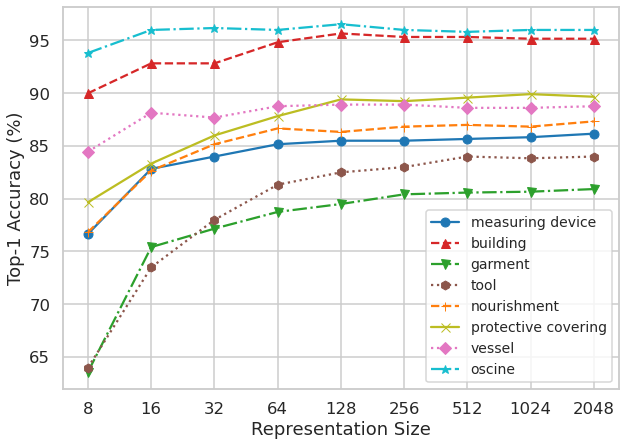

In [85]:
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import pathlib
import seaborn as sns

sns.set_style("whitegrid")
sns.set_context("talk")

tableau_20 = [
    "#9edae5",
    "#17becf",
    "#dbdb8d",
    "#bcbd22",
    "#c7c7c7",
    "#7f7f7f",
    "#f7b6d2",
    "#e377c2",
    "#c49c94",
    "#8c564b",
    "#c5b0d5",
    "#9467bd",
    "#ff9896",
    "#d62728",
    "#98df8a",
    "#2ca02c",
    "#ffbb78",
    "#ff7f0e",
    "#aec7e8",
    "#1f77b4",
]

fig, ax1 = plt.subplots(1, 1, figsize=(9, 6.5))

# Size settings
plt.rc("axes", titlesize=16)  # fontsize of the axes title
plt.rc("axes", labelsize=16)  # fontsize of the axes title
plt.rc("legend", fontsize=14)  # legend fontsize

# X axis settings
plt.xlabel("Representation Size")
# plt.title("Multihead model superclass performance with feature dimensions")
# Y axis settings
plt.ylabel("Top-1 Accuracy (%)")
# plt.ylim([40, 78])

markers = ['o', '^', 'v', 'h', '+', 'x', 'D', '*']
linestyles = ['-', '--', '-.', ':', "--", "-", ":", "-."]
colors = [
    tableau_20[-1],
    tableau_20[13],
    tableau_20[15],
    tableau_20[9],
    tableau_20[-3],
    tableau_20[3],
    tableau_20[7],
    tableau_20[1],
]

for i in range(len(N)-2):
    lab = in_hier.wnid_to_name[superclass_wnid[N[i]]]
#     print(lab)
    if i==0:
        lab = lab.split(', ')[-1]
    elif i==4:
        lab = lab.split(', ')[1]
    else:
        lab = lab.split(', ')[0]
#     print(lab)
    plt.plot(
        np.arange(9),
        100*all_acc[:, N[i]],
        label=f"{lab}",
        c=colors[i],
        marker=markers[i],
        linestyle=linestyles[i]
    )
plt.xticks([i for i in range(9)], [(2**(i+3)) for i in range(9)])
plt.legend()
plt.tight_layout(pad=1.0)

plt.savefig("superclass_acc.pdf")
